In [1]:
import tensorflow as tf

tf.keras.backend.set_floatx("float32")
tf.config.experimental.enable_tensor_float_32_execution(False)
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    Input,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from adjustText import adjust_text

2025-04-04 20:32:13.268132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 20:32:13.274863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743795133.283574  393064 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743795133.286422  393064 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 20:32:13.295230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load MNIST
(x_train, labels_train), (x_val, labels_val) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
y_train = to_categorical(labels_train, 10)
y_val = to_categorical(labels_val, 10)

In [3]:
# Load Nearly-MNIST from CSV
df_nearly = pd.read_csv("./datasets/nearly_mnist.csv")
x_nearly = df_nearly.iloc[:, :-1].values.astype("float32") / 255.0
y_nearly_labels = df_nearly["Labels"].values.astype("int")

x_nearly = x_nearly.reshape(-1, 28, 28, 1)
y_nearly = to_categorical(y_nearly_labels, 10)

In [4]:
# Custom callback to evaluate on MNIST val and Nearly-MNIST each epoch
class ValidationAccLogger(Callback):
    def __init__(self, x_val, y_val, x_extra, y_extra):
        super().__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.x_extra = x_extra
        self.y_extra = y_extra
        self.val_accuracies = []
        self.extra_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        val_acc = self.model.evaluate(self.x_val, self.y_val, verbose=0)[1]
        extra_acc = self.model.evaluate(self.x_extra, self.y_extra, verbose=0)[1]
        self.val_accuracies.append(val_acc)
        self.extra_accuracies.append(extra_acc)

In [5]:
# Define CNN
inputs = Input(shape=x_train.shape[1:])
x = Conv2D(64, (5, 5), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = MaxPool2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
outputs = Dense(10, activation="softmax")(x)

net = Model(inputs=inputs, outputs=outputs)
net.summary()

I0000 00:00:1743795134.929227  393064 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6054 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,685,770 (6.43 MB)

 Trainable params: 1,684,874 (6.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [6]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
)
datagen.fit(x_train)

Epoch 1/30


/home/bentengma/anaconda3/envs/tf218/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743795136.316905  393269 service.cc:148] XLA service 0x55d83de67140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743795136.316931  393269 service.cc:156]   StreamExecutor device (0): NVIDIA RTX 2000 Ada Generation Laptop GPU, Compute Capability 8.9
2025-04-04 20:32:16.354119: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743795136.459334  393269 cuda_dnn.cc:529] Loaded cuDNN version 90800


 10/469 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1193 - loss: 8.7734

I0000 00:00:1743795138.114481  393269 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.4194 - loss: 6.7360 - val_accuracy: 0.1137 - val_loss: 8.8593
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7860 - loss: 4.0655 - val_accuracy: 0.8075 - val_loss: 3.1336
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8664 - loss: 2.7703 - val_accuracy: 0.8504 - val_loss: 2.1829
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8984 - loss: 1.9229 - val_accuracy: 0.9256 - val_loss: 1.4242
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9158 - loss: 1.3472 - val_accuracy: 0.9523 - val_loss: 0.9747
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9293 - loss: 0.9686 - val_accuracy: 0.9564 - val_loss: 0.7145
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9357 - loss: 0.7222 - val_accuracy: 0.9252 - val_loss: 0.6407
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9398 - loss: 0.5722 - val_accuracy: 0.95

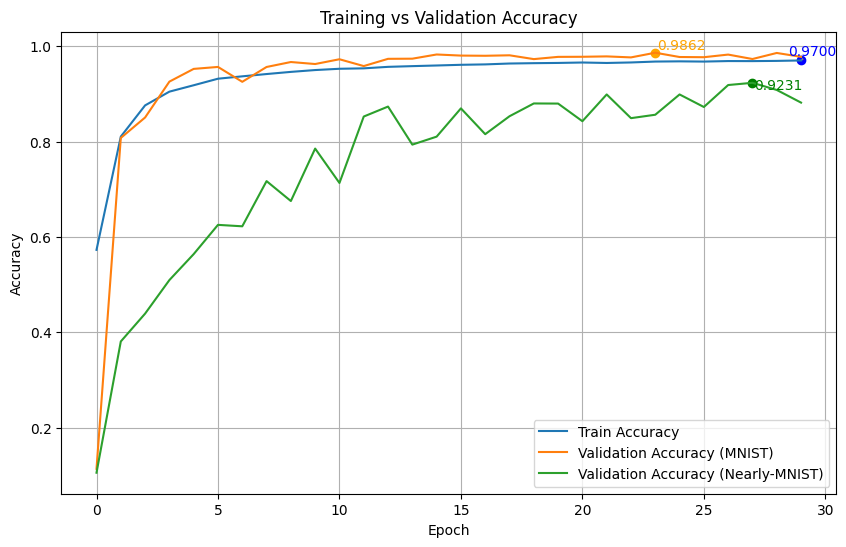

In [7]:
val_logger = ValidationAccLogger(x_val, y_val, x_nearly, y_nearly)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

net.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

history = net.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=[early_stopping, val_logger],
)

plt.figure(figsize=(10, 6))
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
nearly_acc = val_logger.extra_accuracies

plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy (MNIST)")
plt.plot(nearly_acc, label="Validation Accuracy (Nearly-MNIST)")

# Find max points
max_train_epoch = np.argmax(train_acc)
max_val_epoch = np.argmax(val_acc)
max_nearly_epoch = np.argmax(nearly_acc)

# Plot scatter points
plt.scatter(max_train_epoch, train_acc[max_train_epoch], color="blue")
plt.scatter(max_val_epoch, val_acc[max_val_epoch], color="orange")
plt.scatter(max_nearly_epoch, nearly_acc[max_nearly_epoch], color="green")

# Create text labels
texts = []
texts.append(
    plt.text(
        max_train_epoch,
        train_acc[max_train_epoch],
        f"{train_acc[max_train_epoch]:.4f}",
        color="blue",
    )
)
texts.append(
    plt.text(
        max_val_epoch,
        val_acc[max_val_epoch],
        f"{val_acc[max_val_epoch]:.4f}",
        color="orange",
    )
)
texts.append(
    plt.text(
        max_nearly_epoch,
        nearly_acc[max_nearly_epoch],
        f"{nearly_acc[max_nearly_epoch]:.4f}",
        color="green",
    )
)

# Adjust text to avoid overlap, with arrow
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray"))

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
inputs = Input(shape=x_train.shape[1:])

# Conv Block 1
x = Conv2D(64, (3, 3), activation="leaky_relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation="leaky_relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

# Conv Block 2
x = Conv2D(128, (3, 3), activation="leaky_relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation="leaky_relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

# Dense Block
x = Flatten()(x)
x = Dense(256, activation="leaky_relu", kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

outputs = Dense(10, activation="softmax")(x)

net = Model(inputs=inputs, outputs=outputs)
net.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,870,026 (7.13 MB)

 Trainable params: 1,868,746 (7.13 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
)
datagen.fit(x_train)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.4182 - loss: 2.0211 - val_accuracy: 0.1142 - val_loss: 6.1890
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7982 - loss: 0.6815 - val_accuracy: 0.9538 - val_loss: 0.1952
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8709 - loss: 0.4637 - val_accuracy: 0.9421 - val_loss: 0.2281
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9037 - loss: 0.3633 - val_accuracy: 0.9764 - val_loss: 0.1219
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9220 - loss: 0.2985 - val_accuracy: 0.9734 - val_loss: 0.1317
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9345 - loss: 0.2632 - val_accuracy: 0.9836 - val_loss: 0.0993
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9423 - loss: 0.2365 - val_accuracy: 0.9848 - val_loss: 0.0948
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9494 - loss: 0.2147 - 

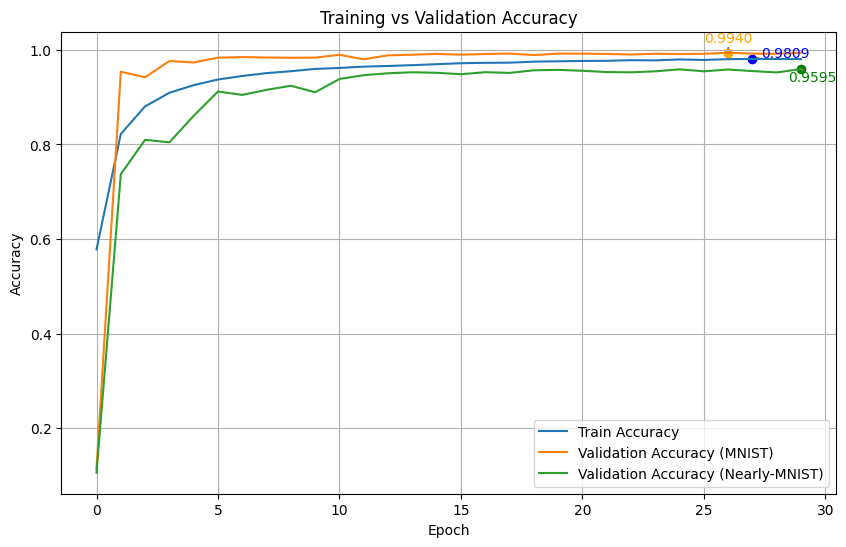

In [10]:
val_logger = ValidationAccLogger(x_val, y_val, x_nearly, y_nearly)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

net.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

history = net.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=[early_stopping, val_logger],
)

plt.figure(figsize=(10, 6))
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
nearly_acc = val_logger.extra_accuracies

plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy (MNIST)")
plt.plot(nearly_acc, label="Validation Accuracy (Nearly-MNIST)")

# Find max points
max_train_epoch = np.argmax(train_acc)
max_val_epoch = np.argmax(val_acc)
max_nearly_epoch = np.argmax(nearly_acc)

# Plot scatter points
plt.scatter(max_train_epoch, train_acc[max_train_epoch], color="blue")
plt.scatter(max_val_epoch, val_acc[max_val_epoch], color="orange")
plt.scatter(max_nearly_epoch, nearly_acc[max_nearly_epoch], color="green")

# Create text labels
texts = []
texts.append(
    plt.text(
        max_train_epoch,
        train_acc[max_train_epoch],
        f"{train_acc[max_train_epoch]:.4f}",
        color="blue",
    )
)
texts.append(
    plt.text(
        max_val_epoch,
        val_acc[max_val_epoch],
        f"{val_acc[max_val_epoch]:.4f}",
        color="orange",
    )
)
texts.append(
    plt.text(
        max_nearly_epoch,
        nearly_acc[max_nearly_epoch],
        f"{nearly_acc[max_nearly_epoch]:.4f}",
        color="green",
    )
)

# Adjust text to avoid overlap, with arrow
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray"))

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
inputs = Input(shape=x_train.shape[1:])

# Conv Block 1
x = Conv2D(64, (3, 3), activation="leaky_relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation="leaky_relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation="leaky_relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

# Conv Block 2
x = Conv2D(128, (3, 3), activation="leaky_relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation="leaky_relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation="leaky_relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

# Dense Block
x = Flatten()(x)
x = Dense(256, activation="leaky_relu", kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

outputs = Dense(10, activation="softmax")(x)

net = Model(inputs=inputs, outputs=outputs)
net.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,055,306 (7.84 MB)

 Trainable params: 2,053,642 (7.83 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [12]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
)
datagen.fit(x_train)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.4116 - loss: 2.0636 - val_accuracy: 0.1500 - val_loss: 5.5585
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8156 - loss: 0.6422 - val_accuracy: 0.9697 - val_loss: 0.1514
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.8871 - loss: 0.4117 - val_accuracy: 0.9668 - val_loss: 0.1539
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9130 - loss: 0.3318 - val_accuracy: 0.9769 - val_loss: 0.1212
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9321 - loss: 0.2702 - val_accuracy: 0.9758 - val_loss: 0.1225
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9403 - loss: 0.2410 - val_accuracy: 0.9823 - val_loss: 0.1056
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.9484 - loss: 0.2184 - val_accuracy: 0.9816 - val_loss: 0.1034
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.9520 - loss: 0.1997 - 

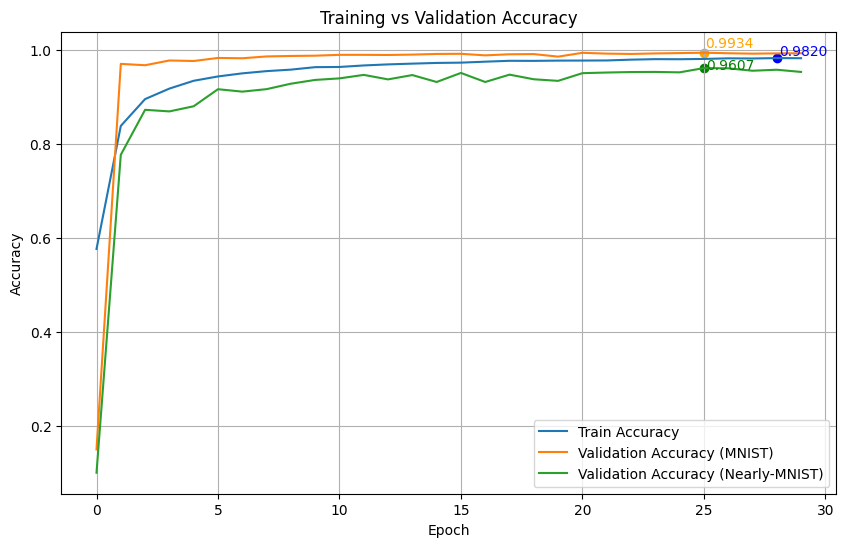

In [13]:
val_logger = ValidationAccLogger(x_val, y_val, x_nearly, y_nearly)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

net.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

history = net.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=[early_stopping, val_logger],
)

plt.figure(figsize=(10, 6))
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
nearly_acc = val_logger.extra_accuracies

plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy (MNIST)")
plt.plot(nearly_acc, label="Validation Accuracy (Nearly-MNIST)")

# Find max points
max_train_epoch = np.argmax(train_acc)
max_val_epoch = np.argmax(val_acc)
max_nearly_epoch = np.argmax(nearly_acc)

# Plot scatter points
plt.scatter(max_train_epoch, train_acc[max_train_epoch], color="blue")
plt.scatter(max_val_epoch, val_acc[max_val_epoch], color="orange")
plt.scatter(max_nearly_epoch, nearly_acc[max_nearly_epoch], color="green")

# Create text labels
texts = []
texts.append(
    plt.text(
        max_train_epoch,
        train_acc[max_train_epoch],
        f"{train_acc[max_train_epoch]:.4f}",
        color="blue",
    )
)
texts.append(
    plt.text(
        max_val_epoch,
        val_acc[max_val_epoch],
        f"{val_acc[max_val_epoch]:.4f}",
        color="orange",
    )
)
texts.append(
    plt.text(
        max_nearly_epoch,
        nearly_acc[max_nearly_epoch],
        f"{nearly_acc[max_nearly_epoch]:.4f}",
        color="green",
    )
)

# Adjust text to avoid overlap, with arrow
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray"))

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()